In [ ]:
!pip install tensorflow_io

In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd
from google.colab import drive

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import librosa

In [ ]:
#loading pretrained YAMnet and function for getting audio ready

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=1000)
    return wav


In [ ]:
#load test file from google drive 

testing_wav_data = load_wav_16k_mono('//content/drive/MyDrive/science fair data/testing data/a0066.wav')


In [ ]:




class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])


scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}') 


#getting training data(need to change)

_ = tf.keras.utils.get_file('heart_sounds.zip',
                        'file:///content/drive/MyDrive/science fair data/heart_sounds.zip', 
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

small_heart_sounds_csv = 'file:///content/drive/MyDrive/science fair data/csv_file.csv'
base_data_path = 'file:///content/drive/MyDrive/science fair data/heart_sounds/all_sounds'

pd_data = pd.read_csv(small_heart_sounds_csv)
pd_data.head()


#dont change mostly 


my_classes = ['Normal', 'Abnormal']
map_class_to_id = {'Normal':0, 'Abnormal':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)




filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec



def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec



# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec



cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)



my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()



my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

The main sound is: Vehicle
The embeddings shape: (4, 1024)


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#training block(will train the net)

history = my_model.fit(train_ds,
                       epochs=25,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/25
144/144 [==============================] - 97s 611ms/step - loss: 0.3882 - accuracy: 0.8232 - val_loss: 0.1366 - val_accuracy: 0.9508
Epoch 2/25
144/144 [==============================] - 1s 10ms/step - loss: 0.3501 - accuracy: 0.8411 - val_loss: 0.1261 - val_accuracy: 0.9593
Epoch 3/25
144/144 [==============================] - 2s 11ms/step - loss: 0.3376 - accuracy: 0.8508 - val_loss: 0.1304 - val_accuracy: 0.9532
Epoch 4/25
144/144 [==============================] - 2s 11ms/step - loss: 0.2972 - accuracy: 0.8719 - val_loss: 0.1155 - val_accuracy: 0.9575
Epoch 5/25
144/144 [==============================] - 1s 10ms/step - loss: 0.2846 - accuracy: 0.8765 - val_loss: 0.1281 - val_accuracy: 0.9563
Epoch 6/25
144/144 [==============================] - 2s 11ms/step - loss: 0.2615 - accuracy: 0.8902 - val_loss: 0.1162 - val_accuracy: 0.9635
Epoch 7/25
144/144 [==============================] - 3s 20ms/step - loss: 0.2500 - accuracy: 0.8908 - val_loss: 0.1304 - val_accuracy: 0.95

In [ ]:
#accuracy

loss, accuracy = my_model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

54/54 [==============================] - 1s 5ms/step - loss: 0.9550 - accuracy: 0.8877
Loss:  0.9550290703773499
Accuracy:  0.8876535892486572


In [ ]:
#classification on trained model

scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()
inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: Abnormal


In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)
    
saved_model_path = './heart_sounds_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)


INFO:tensorflow:Assets written to: ./heart_sounds_yamnet/assets


INFO:tensorflow:Assets written to: ./heart_sounds_yamnet/assets


In [ ]:
reloaded_model = tf .saved_model.load(saved_model_path)
reloaded_results = reloaded_model(testing_wav_data)
Normal_or_Abnormal = my_classes[tf.argmax(reloaded_results)]
print(f'The main sound is: {Normal_or_Abnormal}')

The main sound is: Abnormal


//content/drive/MyDrive/science fair data/testing data/a0066.wav
Waveform values: [ 5.3042957e-09 -5.4644854e-08  6.0277742e-08 ...  1.6515251e-02
  1.3248604e-02  9.9059176e-03]


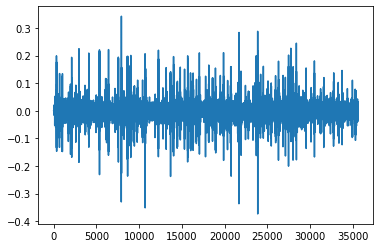

In [ ]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
#filename = row['filename'].item()
filename = '//content/drive/MyDrive/science fair data/testing data/a0066.wav'
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=1000)

In [ ]:
reloaded_results = reloaded_model(waveform)
your_top_class = tf.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[Your model] The main sound is: Abnormal (0.9969605803489685)


In [ ]:
local_path = '/content/drive/MyDrive/heart_sounds_yamnet'
reloaded_model = tf .saved_model.load(local_path)
reloaded_results = reloaded_model(testing_wav_data)
Normal_or_Abnormal = my_classes[tf.argmax(reloaded_results)]
print(f'The main sound is: {Normal_or_Abnormal}')

The main sound is: Normal
